# l4 input checking
### testing the implementation of level 4 inputs as noticed some problems

### Current problem
- intertidal areas are classifying areas that are not tidal (source = problems with ITEMs dataset)
- water persistence not correctly classifying the ocean as persistent

In [1]:
import os, sys, copy
import yaml
import numpy as np
import xarray as xr
import pickle

from itertools import groupby
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

import datacube
from datacube.storage import masking
from datacube.virtual import catalog_from_file
dc = datacube.Datacube()

In [2]:
# AWS or Gadi
service = '/home/jovyan/development/'
# service = '/g/data/u46/users/bt2744/work/code/'

sys.path.append(str(service)+"dea-notebooks/Scripts")
from dea_classificationtools import sklearn_unflatten
from dea_classificationtools import sklearn_flatten

sys.path.append(os.path.abspath(str(service)+"livingearth_australia/le_plugins"))

In [3]:
# loading extents from yaml Dan prepared, just change site_name to tile interested in from our 16 test sites
yaml_sites_file = os.path.abspath(str(service)+"livingearth_lccs_development_tests/notebooks/wcf_mask/au_test_sites.yaml")

with open(yaml_sites_file, "r") as f:
    site_config = yaml.safe_load(f)

site_name = "Coastal Hobart"
extent_x = [site_config[site_name]["min_x"],
            site_config[site_name]["max_x"]]
extent_y = [site_config[site_name]["min_y"],
            site_config[site_name]["max_y"]]

crs = "EPSG:3577"
res = (-25, 25)
time = ("2015-01-01", "2015-12-31")
query =({'time': time,
             'x':extent_x,
            'y':extent_y,
            'crs':crs,
            'resolution':res})

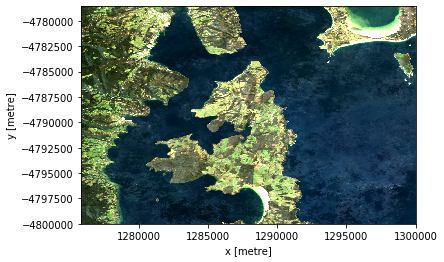

In [4]:
# Load Landsat
geomedian = dc.load(product="ls8_nbart_geomedian_annual", **query)
geomedian = masking.mask_invalid_data(geomedian).squeeze().drop('time')
geomedian[['red', 'green', 'blue']].to_array().plot.imshow(robust=True)

In [ ]:
# datacube functions to load in a virtual product from recipe
catalog = catalog_from_file(service+'livingearth_lccs_development_tests/notebooks/wcf_mask/virtual_product_cat.yaml')

#### load waterper product

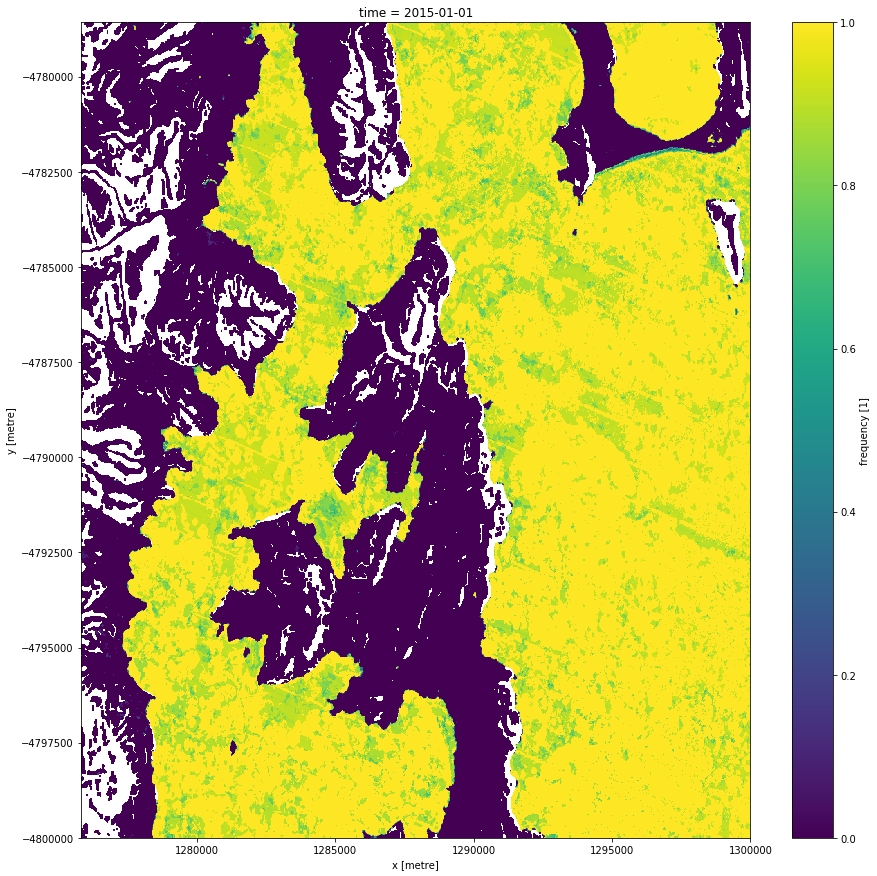

In [11]:
wofs_ann = dc.load(product="wofs_annual_summary", measurements=["frequency"], **query)
wofs_ann = masking.mask_invalid_data(wofs_ann)

# waterper = ((wofs_ann["frequency"] == 0))


# waterper.plot(figsize=(15,15))
wofs_ann.frequency.plot(figsize=(15,15))


#### load intertidal product

In [ ]:
# Load data from datacube
ITEM = dc.load(product="item_v2", measurements=["relative"], **query)
ITEM_mask = ((ITEM["relative"] >= 0.2) & (ITEM["relative"] <= 0.8)).squeeze().drop('time')
ITEM.relative.plot()
# np.unique(ITEM['relative'].values)

In [ ]:
item = dc.load(product="item_v2", measurements=["relative"], **query)
item = masking.mask_invalid_data(item)
item = item.squeeze().drop('time')

item.relative.plot(figsize=(15,15))

# intertidal = (item["relative"] >= 4) & (item["relative"] <= 8)
# intertidal.plot(figsize=(20,20))

# np.unique(item['relative'].values)

#### making fc_veg product
- should be identical to output from FC_summary plugin

In [ ]:
# load fc wofs mask
product = catalog['ls_fc_wofs_masked']
ls_fc_wofs_masked = product.load(dc, **query)

# add water
product = catalog['wofs_daily']
wofs = product.load(dc, **query)
ls_fc_wofs_masked['water'] = wofs.water

In [ ]:
data = ls_fc_wofs_masked

def consecutive_count(tv_numpy, consecutive_numpy, required_consecutive, consec_msk_val=1):
    '''
    function to get consective count of veg (1) for each pixel across the time series

    :param numpy.array tv_numpy: 3-D array of tv[z,y,x]
    :param numpy.array consecutive_numpy: bool output array for veg (1) and non veg (0)
    :param float required_consecutive: how many consectutive 1's to be classified as veg?
    :param float consec_msk_val: what value to calculcate consectutives on
           default is veg (1)     
    '''

    for y in range(tv_numpy.shape[1]):
        for x in range(tv_numpy.shape[2]):
            # If all the values are nan then just set output to nan and carry on",
            pixel = tv_numpy[:,y,x]

            if np.all(np.isnan(pixel)):
                consecutive_numpy[y,x] = np.nan
                continue            

            # get counts of consecutive veg classifications
            counts = [len(list(group)) for label, group in groupby(pixel[(~np.isnan(pixel))]) if label == 1]

            if not counts:
                consecutive_numpy[y,x] = 0
            elif max(counts) >= required_consecutive:
                consecutive_numpy[y,x] = 1
            else:
                consecutive_numpy[y,x] = 0

    return consecutive_numpy


data_nan = masking.mask_invalid_data(data)

# Create water and low-quality fc masks
no_water = np.invert( (data['water'] == 128) | (data['water'] == 132) )
high_ue = (data['UE'] > 30) & no_water

# Set to null areas with high UE, but no water
data_nan = data_nan.where(np.invert(high_ue))

# Don't need this anymore
data_nan = data_nan.drop("UE")
del high_ue

# Where there's water, set PV to 0
data_nan['PV'] = data_nan.PV.where(no_water, 0)
data_nan['NPV'] = data_nan.NPV.where(no_water, 0)

# Where there's water, set BS to 100
data_nan['BS'] = data_nan.BS.where(no_water, 100)

# don't need this anymore
data_nan = data_nan.drop("water")
del no_water

data_month = data_nan.groupby('time.month').median(dim='time')    

# Create mask where PV > BS
PV_dominant = data_month['PV'] > data_month['BS']
PV_dominant_nan = PV_dominant.where((data_month['PV'] >= 0) & (data_month['BS'] >= 0))

# Create mask where NPV > BS
NPV_dominant = data_month['NPV'] > data_month['BS']
NPV_dominant_nan = NPV_dominant.where((data_month['NPV'] >= 0) & (data_month['BS'] >= 0))

# Veg where PV or NPV are greater than BS
tv_mask = (PV_dominant_nan + NPV_dominant_nan)

# make values of 2 == 1 (end result in binary veg mask)
tv_mask_drop = np.where(tv_mask == 2, 1, tv_mask)
tv_mask_xr = xr.DataArray(tv_mask_drop, coords=tv_mask.coords, dims=tv_mask.dims)

# executing consecutive_count function #
# veg = 2 consecutive months
required_consecutive = 2

# Pull tv as numpy array
tv_numpy = tv_mask_xr.values

# Set up array for output (faster to pre-allocate for numba).
# Needs to be float32 for NaN
consecutive_numpy = np.empty((tv_numpy.shape[1], tv_numpy.shape[2]), dtype=np.float32)

# Run function to get array of with 1 where number of consecutive values for different
# dates is >= required_consecutive
consecutive_numpy = consecutive_count(tv_numpy, consecutive_numpy, required_consecutive)

# reduce original array to 2D
# using max here but not important as we just want to use shape/attributes
tv_reduce = tv_mask.max(dim='month')

# create new data array with sampe dimensions as original
fc_veg = xr.DataArray(consecutive_numpy, coords=tv_reduce.coords, dims=tv_reduce.dims)  


#### making wofs_mask product

In [ ]:
# Load data from datacube
wofs_ann = dc.load(product="wofs_annual_summary", measurements=["frequency"], **query)
wofs_mask = 1-((wofs_ann["frequency"] >= 0.2)).squeeze().drop('time')

#### making wcf_mask product
- should be identical to output from wcf_mask plugin

In [ ]:
# load fc wofs mask
product = catalog['geomedian_combined']
geomedian_combined = product.load(dc, **query)

In [ ]:
data = geomedian_combined

model_pickle = str(service)+'livingearth_australia/models/wcf_model.pickle'

"""
Takes an existing model saved out as a pickle file.
"""
# Unpickle model
with open(model_pickle, "rb") as f:
    ml_model_dict = pickle.load(f)

flat = sklearn_flatten(data)
flat = flat/10000
results = ml_model_dict.predict(flat)
predicted_wcf = (sklearn_unflatten(results,data).transpose())[0]

# Currently copying and making a dataset with same size
# Make a deep copy
wcf_mask = copy.deepcopy(predicted_wcf)

# Make an array of zeroes
wcf_mask.values = np.zeros_like(predicted_wcf, dtype='float64')

# Using model to predict woody cover fraction trained on Albert Van Dijk's data
# masking values <= 0.004 as non veg
wcf_mask.values = np.where(predicted_wcf >= 0.004, 1, wcf_mask.values)


In [ ]:
# plot wcf to see what data actually looks like
predicted_wcf.plot(figsize=(10,8))

#### display input for vegetat_veg_cat

In [ ]:
plt.figure(figsize=(25,5))
gs = gridspec.GridSpec(1,4)

ax1=plt.subplot(gs[0,0])
geomedian[['red', 'green', 'blue']].to_array().plot.imshow(robust=True)
ax1.set_title('geomedian')

ax2=plt.subplot(gs[0,1])
fc_veg.plot.imshow()
ax2.set_title('fc_veg')

ax3=plt.subplot(gs[0,2])
wofs_mask.plot.imshow()
ax3.set_title('wofs_mask')

ax4=plt.subplot(gs[0,3])
wcf_mask.plot.imshow()
ax4.set_title('wcf_mask')

plt.tight_layout()
plt.show()

#### display output for vegetat_veg_cat

In [ ]:
vegetat_veg_cat = fc_veg * wofs_mask * wcf_mask
vegetat_veg_cat.plot()